# Fitting Saturated Stars in JWST Imaging Data
***

Author: Varun Bajaj<br>
email: vbajaj@stsci.edu<br>
January 2024

This notebook provides an example workflow for performing Point Spread Function (PSF) fitting photometry for a set of JWST NIRCam Data.  Specifically, it highlights capabilities of the the `one_pass_fitting` package for fitting both unsaturated and saturated stars (stars where the core of the star is `nan` in the data array.  As the saturated star fitting is not broadly tested across multiple cases, we also provide several quality assessment checks, such as computation of astrometric/photometric RMS, as well as offsets from Gaia to validate the precision and accuracy of the fitting.

#### Why would I want to fit saturated stars?
Due to it's high sensitivity, many stars that are saturated in JWST data are often the only high SNR stars in data from other missions, such as HST and Gaia.  This makes cross-matching and aligning datasets from JWST to other observatories difficult.  Additionally, when taking deep images of sparse fields, there may only be a few stars and they become saturated due to the long exposure times.  Furthermore, JWST's broad wavelength coverage may often yield stars being saturated in some filters, but not others, so matching JWST to JWST may be difficult.

In the limited amount of testing done, we have found that positions recovered for the saturated stars can be quite good (~4-6 mas error for NIRCam longwave data), which is more than sufficient for alignment.  The flux precision seems to vary slightly more, but is generally around 5% (the accuracy has of the saturated photometry has not yet been tested).

<div class="alert alert-block alert-warning">
<b>Warning:</b> The saturated star fitting methodology is still very much in beta, and should not be assumed to be "science ready" without careful validation of results
</div>

# Imports and Setup

In [91]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

from astroquery.mast import Observations
from astropy.io import fits
from astropy.table import Table, vstack
from jwst.datamodels import ImageModel, ModelContainer
from jwst.pipeline import  calwebb_image3
from matplotlib.colors import LogNorm
from scipy.stats import sigmaclip, binned_statistic

import one_pass_fitting
from one_pass_fitting import make_jwst_tweakreg_catfile, merge_catalogs, create_image_handlers
from one_pass_fitting.data_handlers import  NIRCamHandler, MIRIHandler # NIRISS coming soon



Simple functions for stats:

In [2]:
def clip(vals):
    return sigmaclip(vals[~np.isnan(vals)], 3. ,3.)[0]

def clipstd(vals):
    return np.std(clip(vals))

def clipmed(vals):
    return np.median(clip(vals))

## Data download

<div class="alert alert-block alert-info">
<b>Warning:</b> This is the dataset we will use an example.  The observations are taken using NIRCAM/LW F277W, and are of the globular cluster M92.  You can change this for your target, but then the discussion of the quality of results in this notebook will not apply.  Also, this notebook assumes you are only running data for one detector/filter.  For for cases with multiple detectors/filters, change as needed.</div>

In [ ]:
# Change as desired
home_dir = os.path.expanduser('~')
data_dir = f'{home_dir}/Documents/OnePassPhot_example_data/JWST'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

os.chdir(data_dir)

In [323]:
det = 'nrcblong'
filt = 'F277W'
pupil = 'CLEAR'

In [102]:
obs = Observations.query_criteria(obs_id='jw01334-o001_t001_nircam_clear-f277w')
plist = Observations.get_product_list(obs)
fplist = Observations.filter_products(plist, productSubGroupDescription='CAL')

# To make the example faster, lets just use the NRC A1 data
# You can replace this data as desired
fplist = vstack([row for row in fplist if row['obs_id'].endswith('nrcblong')])
dl_table = Observations.download_products(fplist)

In [ ]:
for im in sorted(glob.glob('./mastDownload/JWST/*/*cal.fits')):
    shutil.move(im, '.')

In [ ]:
ims = [im for im in sorted(glob.glob('*cal.fits')) if (det in im) and (fits.getval(im, 'filter')==filt) and fits.getval(im, 'pupil')==pupil)]

## PSF Model Generation

To create the PSF models to fit to the stars, we will use `webbpsf`

<div class="alert alert-block alert-warning">
<b>Warning:</b> Change the directory in the next cell to wherever you keep the data files for WebbPSF.  Also, set the environment variable before import WebbPSF (as done in the cell below).</div>

In [93]:
os.environ['WEBBPSF_PATH'] = '/Users/vbajaj/Downloads/webbpsf-data'
import webbpsf

In [5]:
ims = [im for im in sorted(glob.glob('*nrcblong_cal.fits')) if fits.getval(im, 'filter') == 'F277W']

In [7]:
nrc = webbpsf.NIRCam()

In [8]:
def make_nircam_psf(detector: str, filt: str, pupil: str, npsf: int = 9):
    """Get GriddedPSFModel for a given combination of nircam detector/optical element"""
    if detector.lower() in ['along', 'blong']:
        detector = detector.lower().replace('long', '5')
    nrc.detector = 'nrc'+detector.upper()
    
    if pupil.upper() == 'CLEAR':
        nrc.filter = filt.lower()
    else:
        nrc.filter = pupil.lower()
    # 9 is likely too low, probably make it 25
    grid = nrc.psf_grid(num_psfs=npsf, all_detectors=False)
    return grid

In [9]:
model = make_nircam_psf(det.replace('nrc', ''), filt, pupil, npsf=16)  # Change this line for MIRI, or if you want a finer PSF grid


Running instrument: NIRCam, filter: F277W
  Running detector: NRCB5
    Position 1/16: (0, 0) pixels
    Position 1/16 centroid: (201.58716509402382, 201.17430228773964)
    Position 2/16: (0, 682) pixels
    Position 2/16 centroid: (201.58489366740406, 201.13471534176222)
    Position 3/16: (0, 1365) pixels
    Position 3/16 centroid: (201.60034234310106, 201.170335602953)
    Position 4/16: (0, 2047) pixels
    Position 4/16 centroid: (201.57844005351916, 201.23922188706553)
    Position 5/16: (682, 0) pixels
    Position 5/16 centroid: (201.57400486350141, 201.22015422775564)
    Position 6/16: (682, 682) pixels
    Position 6/16 centroid: (201.5659862609878, 201.19802593007734)
    Position 7/16: (682, 1365) pixels
    Position 7/16 centroid: (201.62029862328558, 201.1467152301239)
    Position 8/16: (682, 2047) pixels
    Position 8/16 centroid: (201.57223689722946, 201.24592028724996)
    Position 9/16: (1365, 0) pixels
    Position 9/16 centroid: (201.64388914359105, 201.291112

# PSF Fitting

Let's first go over the basics of `OnePassPhot`

The following values are only relevant for finding and fitting non saturated stars:
  - `hmin` is minimum separation a local maximum in the data has to be from any other local max.  This is like a minimum isolation value of source
  - `fmin` is the minimum flux of the sume of brightest 4 pixels of the local max, it is a rough cut to make sure the local max is bright enough
  - `pmax` is the maximum value of the brightest pixel of the local max.  This often can help make sure you're not fitting saturated sources
  - `sky_in` and `sky_out` are used for calculating a local background around the local max, as the PSF fitting requires the sky to be pre-subtracted

Now let's create the object:

In [182]:
opf = one_pass_fitting.OnePassPhot(model, fmin=80, pmax=500) # fmin and pmax are in data units, so MJy/sr by default for JWST

Performing the saturated star detection/photometry is very similar to the nonsaturated source photometry, but requires that the keyword argument `do_sat` is `True` and that the relevant data quality array is passed in as the `dq` argument.  See the explanation on how the algorithm works (further down) for why the dq array is needed

In [183]:
opf.__call__?

Signature: opf.__call__(data, data_wcs=None, output_name=None, do_sat=False, dq=None)
Docstring:
Perform one-pass photometry on the input image.

Parameters:
-----------
data : numpy.ndarray
    The image data on which to perform photometry.

data_wcs : WCS, optional
    World Coordinate System information for the input data (default is ``None``).

output_name : str, optional
    Output name for writing catalog to file.  For JWST data, ``.ecsv`` is recommended,
    for HST, ``.cat`` is recommended (saved as ascii.commented_header).  If ``None`` no
    file is written out.

do_sat : bool, optional
    Find and measure the saturated stars as well (default is ``False``). Currently only well 
    implemented for JWST

dq : numpy.ndarray
    The data quality array corresponding to ``data``.  Must be passed in if `do_sat` is ``True`` 
Returns:
--------
astropy.table.Table
    A table containing the photometric measurements of the detected stars.  See ``fit_stars`` for details.

Notes:
------

## Running Photometry

In [184]:
tbls = []
for im in ims:
    im_model = ImageModel(im)
    imw = im_model.meta.wcs
    outname  = im.replace('_cal.fits', '_sci1_xyrd.ecsv')

    # If you do not want to find/fit the saturated stars as well, simply set do_sat = False
    tbl = opf(im_model.data, data_wcs=imw, output_name=outname, do_sat=True, dq=im_model.dq)
    tbl.meta['filename'] = outname
 
    tbls.append(tbl)

2024-01-05 18:41:45,608 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting stars


100%|███████████████████████████████| 3463/3463 [00:44<00:00, 77.48it/s]
2024-01-05 18:42:31,245 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting saturated stars


100%|█████████████████████████████████| 983/983 [00:19<00:00, 49.36it/s]
2024-01-05 18:42:51,307 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:334: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])

2024-01-05 18:42:52,454 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting stars


100%|███████████████████████████████| 3444/3444 [00:44<00:00, 77.90it/s]
2024-01-05 18:43:37,583 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting saturated stars


100%|█████████████████████████████████| 952/952 [00:19<00:00, 50.02it/s]
2024-01-05 18:43:56,751 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:334: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])

2024-01-05 18:43:57,670 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting stars


100%|███████████████████████████████| 1562/1562 [00:19<00:00, 79.46it/s]
2024-01-05 18:44:18,172 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting saturated stars


100%|███████████████████████████████| 2027/2027 [00:36<00:00, 54.98it/s]
2024-01-05 18:44:56,229 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting stars


100%|███████████████████████████████| 3498/3498 [00:45<00:00, 77.66it/s]
2024-01-05 18:45:42,221 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:107: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data



Fitting saturated stars


 40%|█████████████▏                   | 389/970 [00:09<00:12, 47.08it/s]2024-01-05 18:45:51,753 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',

2024-01-05 18:45:51,754 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_model_fitting.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  q = np.sum(np.abs(resid)[~nanmask])/np.sum(model.evaluate(xf, yf, *popt)[~nanmask])

100%|█████████████████████████████████| 970/970 [00:19<00:00, 49.93it/s]
2024-01-05 18:46:01,783 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:334: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



### Just the saturated stars

If you **only** want to measure the saturated sources, use the `OnePassPhot.sat_phot` method:

In [185]:
opf.sat_phot?

Signature: opf.sat_phot(data, dq, mod=None, data_wcs=None, output_name=None)
Docstring:
Perform photometry on saturated stars detected in the data.

Parameters
----------
data : numpy.ndarray
    Data array from which to measure stars
dq : numpy.ndarray
    Data quality array indicating pixel flags, needed for finding saturated stars.
mod : GriddedPSFModel, EPSFModel, FittableImageModel, optional
    The PSF model to fit to the stars.  Should usually be GriddedPSFModel.  If ``None`` (default), then sets value to ``self.psf_model``.
data_wcs : WCS, optional
    World Coordinate System information for the input data (default is ``None``).
output_name : str, optional
    Output name for writing catalog to file.  For JWST data, ``.ecsv`` is recommended,
    for HST, ``.cat``is recommended (saved as ascii.commented_header).  If ``None`` no
    file is written out.

Notes:
------
This function uses the data quality array to detect blocks of pixels that have flags 
indicating there is a satur

Uncomment the next block to run just the saturated photometry

In [186]:
# stbls = []
# for im in ims:
#     im_model = ImageModel(im)
#     imw = im_model.meta.wcs
#     outname  = im.replace('_cal.fits', '_sci1_sat.ecsv')
    
#     stbl = opf.sat_phot(im_model.data, im_model.dq, data_wcs=imw, output_name=outname)
#     stbl.meta['filename'] = outname
 
#     stbls.append(stbl)

## Explanation of the saturated star photometry
### Detection
To find the saturated stars the dq array is first searched for blocks of at least 2 contiguous pixels flagged with either a dq value of 1 or 2 (and also with no DQ flag over 8192, to throw out many odd pixels), which correspond to `DO_NOT_USE` and `SATURATED` respectively (oddly, many of the saturated stars are just flagged as `DO_NOT_USE`, rather than saturated).  The area of each of the detected segments is then calculated, and is used as criteria for throwing out detected blocks that are too close together.

### Photometry
The only different consideration for fitting a saturated star vs an unsaturated star is the size of the fitting window.  For unsaturated stars, 5x5 pixels is generally enough.  Since the core of the star in a saturated star is not measured (set to NaN), the size of the fitting window is increased to allow for the wings (which are fairly bright for saturated stars) of the PSF to help constrain the fit.  The size of the window and background measurement annulus are determined by the area of the saturated block of pixels.  Looking at the `npix_fit` column shows the number of pixels actually fit (number of pixels in the window minus the number of pixels in the window that are NaN).  The `pix_flux` column is the sum of the model over the pixels on which it was fit.  This differs from the `f` column, which is the total flux of the model.  This is because the there is flux outside of the window that is not fit, and because the flux of the star in the saturated pixels cannot be fit.  The `pix_flux` column serves to help understand how much "signal" was truly used in computing the fit.

It should be noted that the size of the window and background annulus do have a rather small effect on position (usually under 0.02 pixels), but can affect the computed flux by a few percent.  Optimizing the calculation of the size of the window and annulus is likely important future work.

## Catalog investigation

The column meanings are:
 - `x, y`: x, y position in the output frame (pixels)
 - `m`: "instrumental" magnitude (-2.5log(flux)). This is not meaningful for JWST due to the units being MJy/sr, but is for HST.
 - `q`: quality of fit defined as sum(abs(data-model))/flux
 - `s`: local sky value
 - `cx`: central excess value, which the excess of the flux in the central pixel divided by the fit flux, if negative, the model has more flux in the central pixel than the data
 - `f`: Fit flux, in instrumental units (scaling factor applied to PSF model)
 - `pix_flux`: Sum of fit model over the pixels on which the model was fit
 - `npix_fit`: Number of fit pixels (this changes for saturated sources)
 - `sat`: Whether the star is saturated or not (is the peak pixel value a nan?)
- `RA, Dec`: Right ascension, declination of the `(x,y)` coordinate

In [187]:
tbls[0]

x,y,m,q,s,cx,f,pix_flux,npix_fit,sat,RA,Dec
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
556.8884589085088,8.826168320165817,-5.831055481714362,0.034527972640700795,0.3504617588642316,-0.0017996221876793023,214.9919469644101,162.37676522540593,25.0,0.0,259.29742188474006,43.15574057809827
940.3290614193434,8.566807934911566,-6.530022592570636,0.03271892329636264,0.306947946836407,-0.0007125157052882106,409.2691759299163,311.8579526251477,25.0,0.0,259.30660203177064,43.15690353720601
1643.600347447856,8.620651789829848,-5.928061893438636,0.024602939667570677,0.1915348084164068,0.001922512749693609,235.08491245383834,176.59090026960055,25.0,0.0,259.3234199896232,43.15897964639384
1167.2917939914273,11.346582136870119,-5.888012820219543,0.035217412062719514,0.16199867803855295,-0.004767899439429512,226.5714208087879,171.55032254037695,25.0,0.0,259.3120411820057,43.157531169653495
1389.9965346816728,11.620454839442031,-5.743437724192789,0.021490033230780626,0.17459576512160507,-0.001735521637657796,198.32391621996686,151.03725814048263,25.0,0.0,259.3173666274346,43.15818427590081
7.647467737182247,12.620447332546252,-5.857086725682134,0.029643448077420875,0.24410547774571634,0.001791009585898376,220.20881013228038,162.99608476969783,25.0,0.0,259.28423772762426,43.15397680012321
...,...,...,...,...,...,...,...,...,...,...,...
628.9209818397097,392.3405148269629,-7.127810985738564,0.4089098429667198,0.02714565084941345,nan,709.7810403339394,350.85892488597557,23.0,1.0,259.30080669881715,43.14922589429197
762.2087642333737,1497.8417378716451,-7.12204159554974,0.03788113360112089,0.8924478393205462,nan,706.0194056264762,344.4857144145157,22.0,1.0,259.308683587013,43.13049181775474


To see the differences between the saturated and unsaturated stars, we can first look at how the fit quality changes when stars become more and more saturated
As the stars become more and more saturated, the fit quality degrades.  This is likely because as the stars get brighter, more pixels fit, which allows for more contamination/pixel noise

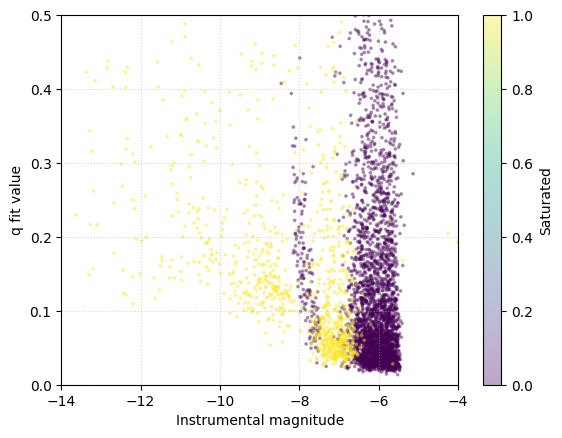

In [192]:
plt.scatter(tbls[0]['m'], tbls[0]['q'], c=tbls[0]['sat'], s=3, alpha=.35)
plt.xlabel('Instrumental magnitude') # just -2.5log(f)
plt.ylabel('q fit value')
plt.ylim(0,.5)
plt.xlim(-14,-4)

cb = plt.colorbar()
cb.set_label('Saturated')

plt.grid(ls=':', alpha=.5)

We can also see just how much of the reported flux is actually fit by the model.  For the unsaturated stars, this value is fairly constant, as expected (as this is mostly just governed by the encircled energy).  However, for the saturated stars, as the star gets brighter more of the flux is lost to the saturated pixels, so the fraction of the flux actually fit drops significantly.  However, the total of fit flux does still generally increase

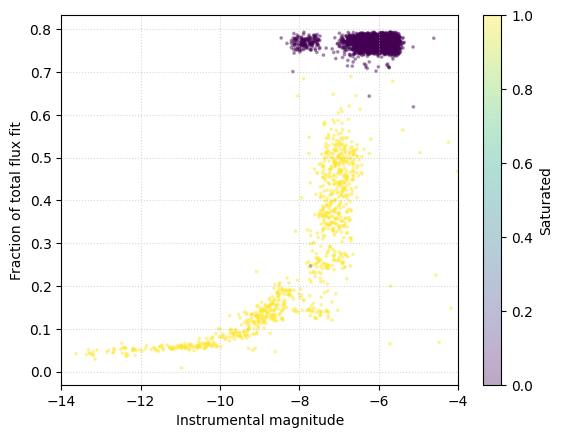

In [193]:
plt.scatter(tbls[0]['m'], tbls[0]['pix_flux']/tbls[0]['f'], c=tbls[0]['sat'], s=3, alpha=.35)
plt.xlabel('Instrumental magnitude') # just -2.5log(f)
plt.ylabel('Fraction of total flux fit')

plt.xlim(-14,-4)

cb = plt.colorbar()
cb.set_label('Saturated')

plt.grid(ls=':', alpha=.5)

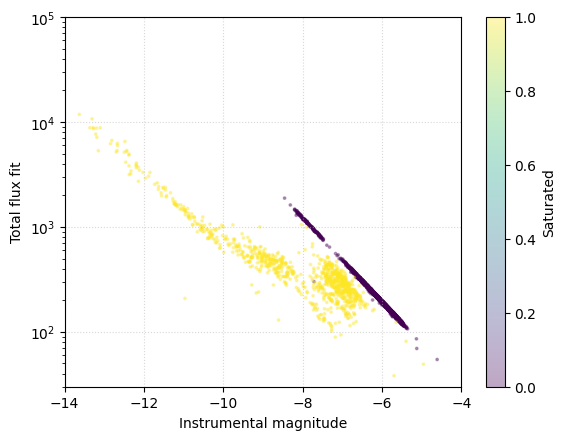

In [194]:
plt.scatter(tbls[0]['m'], tbls[0]['pix_flux'], c=tbls[0]['sat'], s=3, alpha=.35)
plt.xlabel('Instrumental magnitude') # just -2.5log(f)
plt.ylabel('Total flux fit')

plt.yscale('log')
plt.xlim(-14,-4)
plt.ylim(3E1, 1E5)

cb = plt.colorbar()
cb.set_label('Saturated')

plt.grid(ls=':', alpha=.5)

### Simple quality cuts

In [195]:
for t in tbls:
    # This ensures that the "saturated" objects are at least brighter than the background (some are just random bad pixels)
    sat_mask = ((t['npix_fit']*t['s']) < t['pix_flux']) | (t['sat']==0.)
    t = t[sat_mask]

    # This filters out any of the unsaturated sources that were just bad fits
    unsat_mask = ((t['q'] < .5) & (t['m']<0.)) | (t['sat']==1.)
    t = t[unsat_mask]

#  Analysis

To analyze how well the algorithm worked, we can do a few simple tests.  First, we will align the images to each other, and then align the set of images as one group to the Gaia frame.  This will allow us to analyze the precision (by comparing the positions from image to image) and accuracy (by comparing them to Gaia).  Furthermore, we can look at how repeatably the flux is measured for the saturated stars vs the unsaturated stars, and even compare the fit fluxes to Gaia.

## Alignment
We first align the images to each other, and then as a group to Gaia using the JWST pipeline.  Since we have PSF fit positions from the fitting step above, we can use these measurements to do the alignment.

<div class="alert alert-block alert-info">
<b>Note:</b> To do the alignment, we will specifically exclude the saturated stars.  While this isn't strictly necessary in the example case, it will allow us to not bia the results by aligning the data with the saturated measurements.  It is possible that other filters/instruments will have systematic errors on the saturated star fits, which could introduce errors into the astrometry.   </div>

In [196]:
unsat_tbls = [tbl[tbl['sat']==0.] for tbl in tbls]  # keeps only the rows where the star isnt saturated

In [197]:
unsat_catfile = make_jwst_tweakreg_catfile(ims, unsat_tbls, catfile_name='tweakreg_unsat_catfile.txt')

Wrote tweakreg catfile to tweakreg_unsat_catfile.txt


In [361]:
from jwst.resample.resample_utils import make_output_wcs
from jwst.tweakreg.astrometric_utils import compute_radius, get_catalog
from astropy.time import Time

def create_gaia_cat(ims, pm_only=True, epoch=None):
    """
    Creates a gaia catalog with optional proper motion filtering, and epoch correction

    This function computes the coordinate and radius for which to query Gaia DR3, and gets the Gaia sources within that radius.
    If pm_only is True, then sources without proper motions in the gaia catalog are filtered out.  This can be necessary in many cases,
    see https://github.com/spacetelescope/jwst/issues/8168 for details.

    To not use any of the Gaia proper motions, set pm_only to False and epoch to 2016.0
    """
    input_models = [ImageModel(im) for im in ims]
    outwcs = make_output_wcs(input_models)
    radius, fiducial = compute_radius(outwcs)
    if epoch is None:
        epoch = Time(input_models[0].meta.observation.date).decimalyear

    gaia_cat = get_catalog(fiducial[0], fiducial[1], epoch=epoch, sr=radius, catalog='GAIADR3')
    
    gaia_cat.rename_column('ra', 'RA')
    gaia_cat.rename_column('dec', 'DEC')

    if pm_only:
        gaia_cat = gaia_cat[~gaia_cat['pmra'].mask]
    return gaia_cat
    

In [390]:
gcat = create_gaia_cat(ims, pm_only=True)

In [378]:
# No proper motion
# gcat = create_gaia_cat(ims, pm_only=False, epoch=2016.0)

In [203]:
gcat.write('gaia_pm_only.ecsv', overwrite=True)

In [365]:
# Consider varying the sigma, tolerance, abs_tolerance and abs_sigma values to get better results for your dataset
# The rms from image to image, if you have a good number of stars, should be a few milliarcsec for nircam
# To gaia, it should be less than 10 mas if not better

im3_pipe = calwebb_image3.Image3Pipeline()

im3_pipe.tweakreg.use_custom_catalogs = True
im3_pipe.tweakreg.catfile = unsat_catfile
im3_pipe.tweakreg.fitgeometry = 'rscale'
im3_pipe.tweakreg.sigma = .25
im3_pipe.tweakreg.tolerance = .1 # Can really crank down on the tolerance because our positions are so precise 
im3_pipe.tweakreg.expand_refcat = False

# If the next lines are commented out, no absolute alignment will be performed.
im3_pipe.tweakreg.abs_refcat = 'gaia_pm_only.ecsv' # see the note in create_gaia_cat for why this isn't just set to GAIADR3
im3_pipe.tweakreg.abs_fitgeometry = 'general'
im3_pipe.tweakreg.abs_tolerance = 0.1
im3_pipe.tweakreg.abs_sigma = .2
im3_pipe.tweakreg.abs_nclip = 10
im3_pipe.tweakreg.save_abs_catalog = True
aligned_mc = im3_pipe.tweakreg.run(ims)

2024-01-05 20:17:28,562 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2024-01-05 20:17:28,564 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-01-05 20:17:28,566 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2024-01-05 20:17:28,568 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2024-01-05 20:17:28,569 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-01-05 20:17:28,571 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2024-01-05 20:17:28,572 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2024-01-05 20:17:28,828 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (['jw01334001001_02101_00001_nrcblong_cal.fits', 'jw01334001001_02101_00002_nrcblong_cal.fits', 'jw01334001001_02101_00003_nrcblong_cal.fits', 'jw01334001001_02101_00004_nrcblong_cal.fits'],).
20

## Create the master catalog
By creating the master catalog, we crossmatch the stars across the images, allowing to compute the means and standard deviations for all of the quantities from the individual image tables

In [366]:
im_handlers = create_image_handlers([*aligned_mc], tbls) # need to pass the images that were actually aligned above
for ih in im_handlers:
    ih.correct_catalog(aperture=False, pixel_area=False, encircled=False)

removing 4 sources for being off of frame or being bad fits
removing 1 sources for being off of frame or being bad fits
removing 2 sources for being off of frame or being bad fits


In the next cell, we will create the master catalog, and cut it so it only contains stars that were detected at least 3 times

In [367]:
res = merge_catalogs(im_handlers, match_size=0.4)
res_cut = res[res['n'] >= 3]

2024-01-05 20:17:49,040 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/astropy/utils/metadata.py:385: MergeConflictWarning: Cannot merge meta key 'filename' types <class 'str'> and <class 'str'>, choosing filename='jw01334001001_02101_00002_nrcblong_sci1_xyrd.ecsv'
  warnings.warn(

2024-01-05 20:17:49,040 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/astropy/utils/metadata.py:385: MergeConflictWarning: Cannot merge meta key 'filename' types <class 'str'> and <class 'str'>, choosing filename='jw01334001001_02101_00003_nrcblong_sci1_xyrd.ecsv'
  warnings.warn(

2024-01-05 20:17:49,040 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/astropy/utils/metadata.py:385: MergeConflictWarning: Cannot merge meta key 'filename' types <class 'str'> and <class 'str'>, choosing filename='jw01334001001_02101_00004_nrcblong_sci1_xyrd.ecsv'
  warnings.warn(



Creating output WCS grid
Clustering points based on position in output frame. This may take a while.
Separating 16884 points into 8 blocks to reduce memory usage when clustering
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
4 blocks at size [4273, 4311, 4137, 4163]
Clustering points based on position in the output frame. This may take a while.


100%|█████████████████████████████████████| 4/4 [00:00<00:00,  9.98it/s]


Found 5682 groups from 16884 measurements.
Collating matches, computing means


2024-01-05 20:17:50,469 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/astropy/table/groups.py:275: RuntimeWarning: Mean of empty slice
  vals = np.array([func(par_col[i0:i1]) for i0, i1 in zip(i0s, i1s)])



Computing standard deviations


2024-01-05 20:17:54,080 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

2024-01-05 20:17:57,906 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/astropy/utils/metadata.py:385: MergeConflictWarning: Cannot merge meta key 'name' types <class 'str'> and <class 'str'>, choosing name='std'
  warnings.warn(



### Results

Let's look at the centroid precision for stars that were always saturated, or never saturated

In [372]:
satmask = res_cut['sat_mean'] == 1.
unsatmask = res_cut['sat_mean'] == 0.
print('RMS in pixels')
print('Satured x rms:  ', clipmed(res_cut['x_std'][satmask]), 'Satured y rms:  ', clipmed(res_cut['y_std'][satmask]))
print('Unsatured x rms:', clipmed(res_cut['x_std'][unsatmask]), 'Unsatured y rms:', clipmed(res_cut['y_std'][unsatmask]))

RMS in pixels
Satured x rms:   0.020351693640053604 Satured y rms:   0.04948783756320668
Unsatured x rms: 0.007440037483367044 Unsatured y rms: 0.008171324705380215


In the example case, the saturate star RMS is somewhat higher, notably in the y direction.  Though the overall level is still quite low at about 0.05 pixels in quadrature.  For the example case, that is about 3 mas, which is more than acceptable for alignment

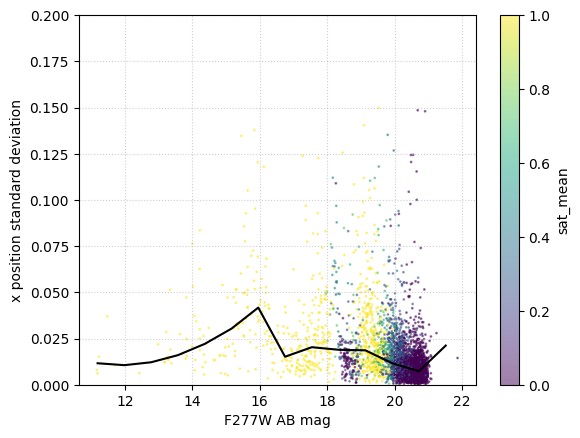

In [369]:
plt.scatter(res_cut['AB_mean'], res_cut['x_std'], s=1, alpha=.5, c=res_cut['sat_mean'], vmax=1)
stat, bedges, bn = binned_statistic(res_cut['AB_mean'], res_cut['x_std'], bins=17, range=(10,23.5), statistic=clipmed)
bcs = (bedges[1:]+bedges[:-1])/2.
cb = plt.colorbar()
plt.plot(bcs, stat, c='k')

plt.xlabel(f'{filt} AB mag')
plt.ylabel('x position standard deviation')

plt.ylim(0,0.2)
plt.grid(ls=':', alpha=.6)

cb.set_label('sat_mean')

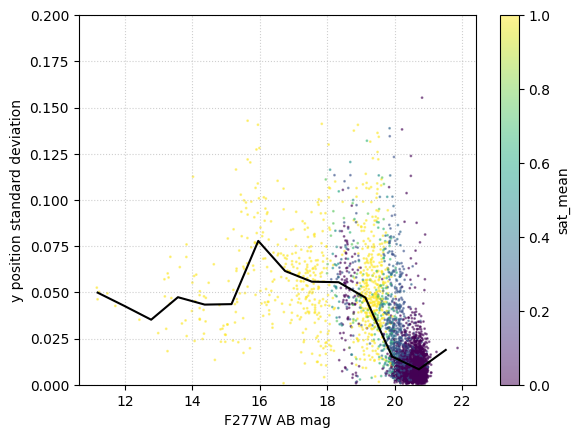

In [370]:
plt.scatter(res_cut['AB_mean'], res_cut['y_std'], s=1, alpha=.5, c=res_cut['sat_mean'], vmax=1)
stat, bedges, bn = binned_statistic(res_cut['AB_mean'], res_cut['y_std'], bins=17, range=(10,23.5), statistic=clipmed)
bcs = (bedges[1:]+bedges[:-1])/2.
cb = plt.colorbar()
plt.plot(bcs, stat, c='k')

plt.xlabel(f'{filt} AB mag')
plt.ylabel('y position standard deviation')

plt.ylim(0,0.2)
plt.grid(ls=':', alpha=.6)

cb.set_label('sat_mean')

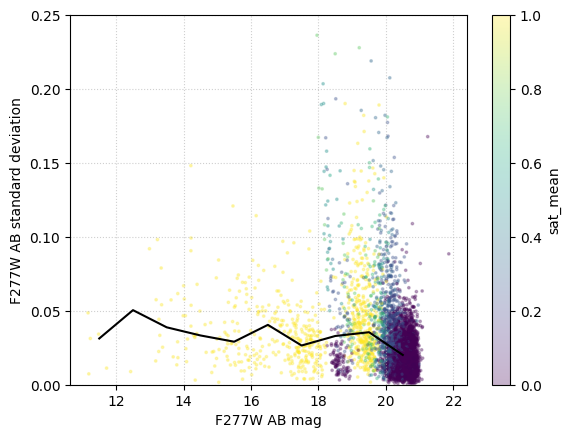

In [373]:
plt.scatter(res_cut['AB_mean'], res_cut['AB_std'], s=3, alpha=.3, c=res_cut['sat_mean'], vmax=1)
stat, bedges, bn = binned_statistic(res_cut['AB_mean'], res_cut['AB_std'], bins=11, range=(10,21), statistic=clipmed)
bcs = (bedges[1:]+bedges[:-1])/2.

cb = plt.colorbar()
plt.plot(bcs, stat, c='k')

plt.xlabel(f'{filt} AB mag')
plt.ylabel(f'{filt} AB standard deviation')

plt.ylim(0,0.25)
plt.grid(ls=':', alpha=.6)

cb.set_label('sat_mean')

## Comparing to Gaia

### Matching
First, we match the master catalog to the Gaia catalog

In [374]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [379]:
gsc = SkyCoord(gcat['RA']*u.deg, gcat['DEC']*u.deg)
jsc = SkyCoord(res_cut['RA_mean']*u.deg, res_cut['Dec_mean']*u.deg)

In [380]:
idx, ang, _ = gsc.match_to_catalog_sky(jsc)

Text(0.5, 0, 'distance [arcsec]')

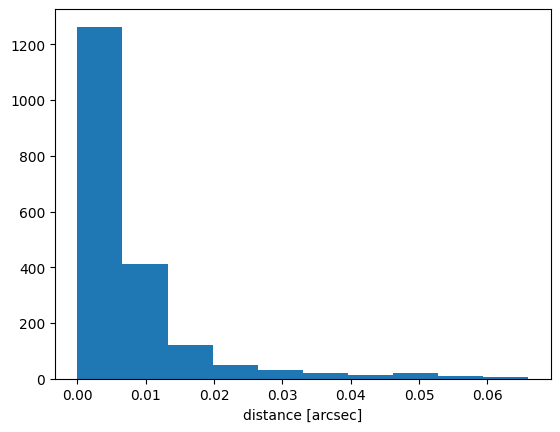

In [381]:
plt.hist(ang.arcsec, range=(0,.066))
plt.xlabel('distance [arcsec]')

In [382]:
dmask = ang.arcsec*1000. < 30 # ~ half a pixel limit for considering stars "matched"
mj = res_cut[idx][dmask]
mg = gcat[dmask]

### Astrometric Offsets
We can now see how the positions of the stars compare to gaia as a function of magnitude

In [383]:
dra = ((mj['RA_mean'] - mg['RA']) * np.cos(mg['DEC']*np.pi/180.)) * 3600.
ddec = (mj['Dec_mean'] - mg['DEC']) * 3600.
separation = ang.arcsec[dmask]

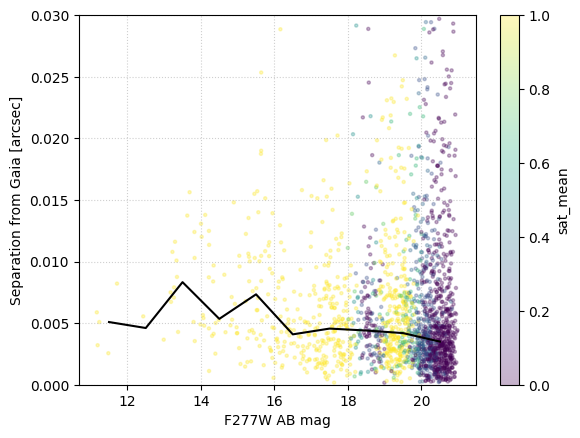

In [384]:
plt.scatter(mj['AB_mean'], separation, s=5, alpha=.3, c=mj['sat_mean'], vmax=1)
stat, bedges, bn = binned_statistic(mj['AB_mean'], separation, bins=11, range=(10,21), statistic=clipmed)
bcs = (bedges[1:]+bedges[:-1])/2.

cb = plt.colorbar()
plt.plot(bcs, stat, c='k')

plt.xlabel(f'{filt} AB mag')
plt.ylabel('Separation from Gaia [arcsec]')

plt.ylim(0,0.03)
plt.grid(ls=':', alpha=.6)

cb.set_label('sat_mean')

Text(0.5, 1.0, 'Offset vectors')

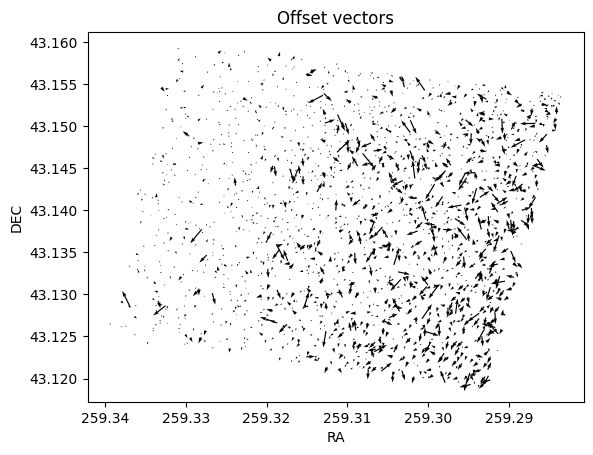

In [385]:
plt.quiver(mj['RA_mean'], mj['Dec_mean'], dra, ddec, scale=.8)
plt.xlim(plt.xlim()[::-1])

plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Offset vectors')

We can also compare the individual image catalogs:

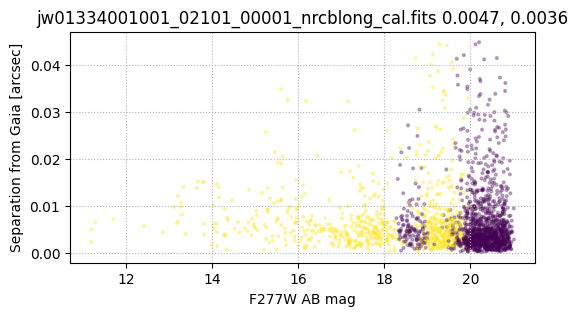

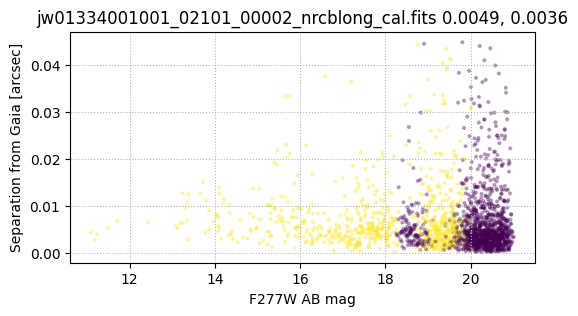

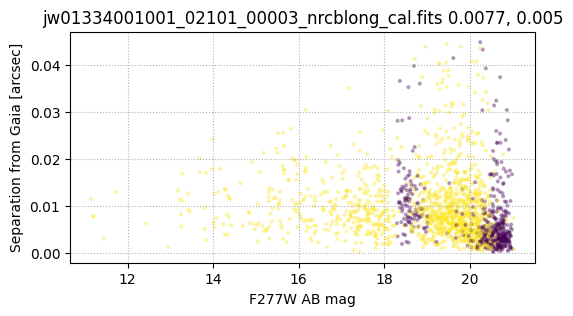

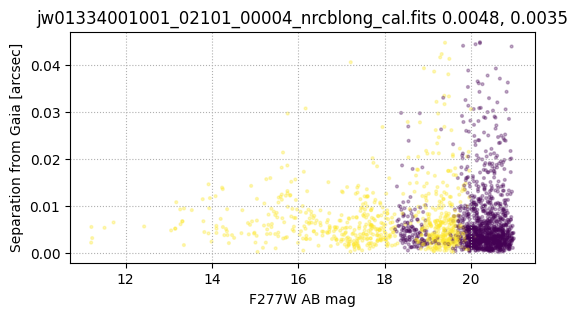

In [386]:
for i, ih in enumerate(im_handlers):
    
    icat = ih.catalog
    isc = SkyCoord(icat['RA']*u.deg, icat['Dec']*u.deg)
    idx, ang, _ = gsc.match_to_catalog_sky(isc)
    imask = ang.arcsec < .045
    micat = icat[idx][imask]
    sep = gsc[imask].separation(isc[idx][imask])

    satmask = micat['sat'] == 1.
    fig = plt.figure(figsize=(6,3))
    plt.scatter(micat['AB'], sep.arcsec, c=micat['sat'], s=4, alpha=.3)
    plt.title(f'{ims[i]} {np.round(clipmed(sep[satmask]*3600),4)}, {np.round(clipmed(sep[~satmask]*3600),4)}')
    plt.grid(ls=':')
    plt.xlabel(f'{filt} AB mag')
    plt.ylabel('Separation from Gaia [arcsec]')

### Photometric Comparison

Because we have the full Gaia catalog, we can do basic comparisons between the psf fit magnitude and the Gaia magnitudes.

First, let's just plot the magnitudes vs each other.  This can help show any obvious issues with the photometry (i.e. discontinuities/biases)

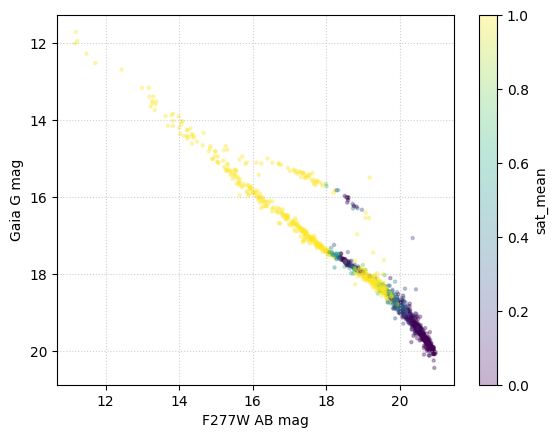

In [387]:
plt.scatter(mj['AB_mean'], mg['mag'], s=5, alpha=.3, c=mj['sat_mean'], vmax=1., vmin=0.)
cb = plt.colorbar()
plt.ylim(plt.ylim()[::-1])
plt.grid(ls=':', alpha=.6)

plt.xlabel(f'{filt} AB mag')
plt.ylabel('Gaia G mag')

# plt.ylim(0,0.03)
plt.grid(ls=':', alpha=.6)

cb.set_label('sat_mean')

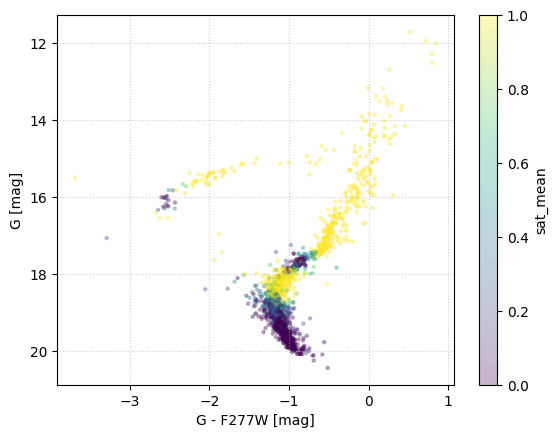

In [388]:
plt.scatter(mg['mag']-mj['AB_mean'], mg['mag'], s=5, alpha=.3, c=mj['sat_mean'], vmax=1., vmin=0.)
cb = plt.colorbar()
plt.ylim(plt.ylim()[::-1])
plt.grid(ls=':', alpha=.6)
plt.xlabel(f'G - {filt} [mag]')
plt.ylabel('G [mag]')

cb.set_label('sat_mean')

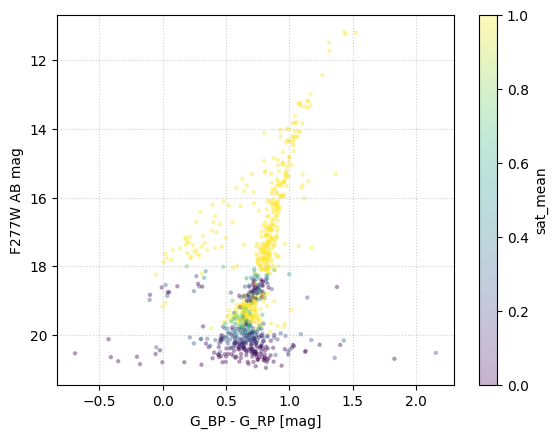

In [389]:
plt.scatter(mg['phot_bp_mean_mag']-mg['phot_rp_mean_mag'], mj['AB_mean'],  s=5, alpha=.3, c=mj['sat_mean'], vmax=1., vmin=0.)
cb = plt.colorbar()
plt.ylim(plt.ylim()[::-1])
plt.grid(ls=':', alpha=.6)
plt.xlabel(f'G_BP - G_RP [mag]')
plt.ylabel(f'{filt} AB mag')

cb.set_label('sat_mean')

Saving the aligned images/catalogs

In [294]:
# for mod in aligned_mc:
#     mod.save(mod.meta.filename.replace('cal.fits', 'aligned.fits'))

In [470]:
# res_cut.write('res_cut.ecsv')

In [295]:
# mj.write('matched_j.ecsv', overwrite=True)
# mg.write('matched_g.ecsv', overwrite=True)

# Conclusion
Overall, it appears from the test dataset that while the saturated star's positional precision is lower than the unsaturated stars, it is more than accurate for alignment, with offsets less than 0.15 pixels (10 mas) to Gaia for the individual measurement, and typically less than 5 mas when comparing to the master catalog, which averages 4 images' catalogs.

When analyzing the error budget, it is worth considering how much of the error is due to Gaia.  In the case of the example, a significant portion of the error is likely coming from the Gaia proper motions being less precise for the unsaturated sources.  That is shown by the astrometric offsets between the saturated stars to gaia being **lower** than the unsaturated ones, as the saturated stars are brighter, and thus likely more accurately measured in Gaia.  In fact, in many cases, it can be optimal to *not use any proper motions*.  While this causes the overall motion of stars to be left out of the alignment, it also can reduce the effects of the proper motion error significantly, and allow the use of the stars that do not have proper motions in the alignment.  When not using the proper motions, the offsets from gaia from both populations of stars are actually lower.  It may be worth trying this on your own data as well.

Note: You may have noticed that there is an odd population of "unsaturated" stars that are brighter than the dimmest saturated stars.  Currently, this has not been investigated, however it is suspected to be "soft saturated" stars, i.e. those that might be saturated in some of the frames of the group, but not all, so the star simply appears a bit nonlinear rather than saturated.

We welcome suggestions, and results of the usage of the tools on your own data!  For any questions, contact vbajaj@stsci.edu

***
<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>